In [1]:
import sys
sys.path.append('..\\helpers')

import cv2
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from loguru import logger
import pandas as pd
import seaborn as sns
from PIL import Image, ImageDraw
from functools import reduce

from pywt import dwt2
import math
from scipy import ndimage


# From helpers directory
from preprocessing import Preprocessor
import display


preprocessor = Preprocessor()

plt.rcParams['figure.figsize'] = (20, 18)
plt.style.use('classic')
plt.subplots_adjust(wspace=0, hspace=0)
sns.set()

# To allow auto reload to this notebook after modifying any external file imported
%load_ext autoreload
%autoreload 2

<Figure size 640x480 with 0 Axes>

## Exploratory Data Analysis

Understanding data structure and setting global variables

In [2]:
dataset_folder_paths = [(x[0].split("\\")[-1], x[0]) for x in os.walk("..\\dataset")][1:]
dataset_folder_paths

[('groundtruth', '..\\dataset\\groundtruth'),
 ('images', '..\\dataset\\images'),
 ('masks', '..\\dataset\\masks'),
 ('overlay', '..\\dataset\\overlay'),
 ('processed', '..\\dataset\\processed'),
 ('images', '..\\dataset\\processed\\images'),
 ('overlay', '..\\dataset\\processed\\overlay')]

Preparing a dataframe to summarize the dataset

In [3]:
positive_labelled_images = []
negative_labelled_images = []

dataset = []

labels = ["positives", "negatives"]

for idx, object in enumerate(labels):
        with open(f'..\\dataset\\{str(object)}.txt') as f:
            lines = f.read().splitlines()
            
            for line in lines:
                if line != "":
                    new_path = os.path.join(dataset_folder_paths[1][1], line)
                    
                    dataset.append((str(object), line))
                    positive_labelled_images.append(new_path) if str(object) == 'positives' else negative_labelled_images.append(new_path)

dataset_df = pd.DataFrame(dataset, columns=['class', 'filename'])
dataset_df.sample(10)

,class,filename
291,negatives,50996972_ce5e5e18a261cd29_MG_R_ML_ANON.tif
302,negatives,50997434_97ec8cadfca70d32_MG_L_ML_ANON.tif
250,negatives,50993922_de5e8d61e501a71b_MG_R_ML_ANON.tif
288,negatives,50996854_fdf4a1516f88b280_MG_L_CC_ANON.tif
67,positives,24065251_c4b995eddb3c510c_MG_L_ML_ANON.tif
140,negatives,22580015_6200187f3f1ccc18_MG_R_CC_ANON.tif
185,negatives,22679036_b9a4da5f2dae63a9_MG_L_ML_ANON.tif
202,negatives,24055806_f0f1a133837b5137_MG_R_CC_ANON.tif
334,negatives,50999246_cb65e8dac169f596_MG_L_ML_ANON.tif
301,negatives,50997304_9054942f7be52dd9_MG_R_CC_ANON.tif


Dataset Summary

In [4]:
dataset_df.describe()

,class,filename
count,410,410
unique,2,410
top,negatives,20586908_6c613a14b80a8591_MG_R_CC_ANON.tif
freq,303,1


In [5]:
# Checking if we have duplicate files, all good!
len(dataset_df["filename"].unique())

410

<Axes: >

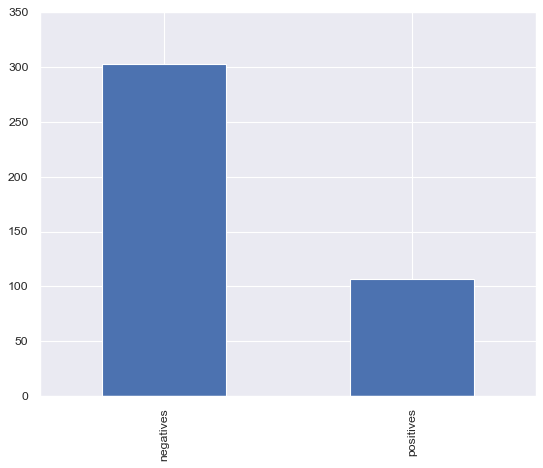

In [6]:
# balanced classes
dataset_df['class'].value_counts().plot(kind='bar')

Visualizing the dataset

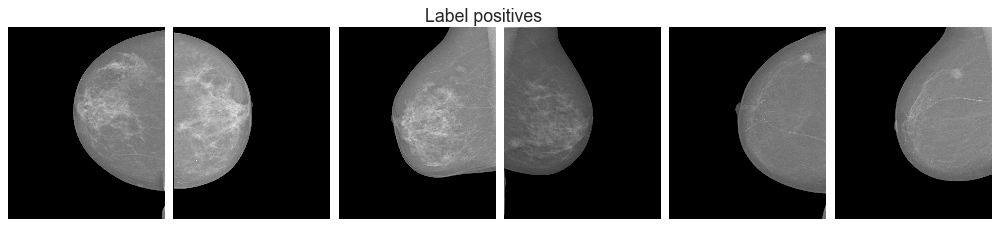

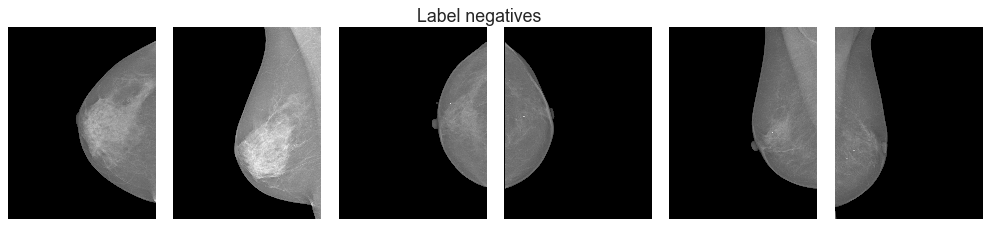

In [7]:
for idx, lbl in enumerate(labels):
    nrows, ncols = 1, 6
    fig, ax = plt.subplots(nrows, ncols, figsize=(16, 3))
    plt.subplots_adjust(wspace=0, hspace=1)

    for idx, fname in enumerate(dataset_df.loc[dataset_df['class'] == lbl]['filename'][:ncols]):
        img = Image.open(os.path.join(dataset_folder_paths[1][1],fname))
        plt.subplot(nrows, ncols, idx+1)
        plt.imshow(np.array(img), cmap='gray')
        fig.suptitle(f'Label {lbl}', fontsize=16)
        plt.axis('off')


## Pre-processing

Pre-processing steps:
1. Image rescaling by a factor of 4
2. The breast profile is pre-segmented using a simple threshold and then the redundant background is cropped away in the dataset.
3. The pixel values in the image are linearly rescaled to 16-bit
4. Contrast limited adaptive histogram equalization (CLAHE) is then applied. The number of tiles in CLAHE is set as {4, 4}, which is arbitrarily chosen, and the contrast enhancement limit is set as 0.01 (default).

Those processes are done firstly on a single image for testing purpsose before modifying the original dataset.

Resized Image Shape: (1331, 1024, 3)
Gray Image Shape: (1331, 1024)
Thresholded Mask Shape: (1331, 1024)


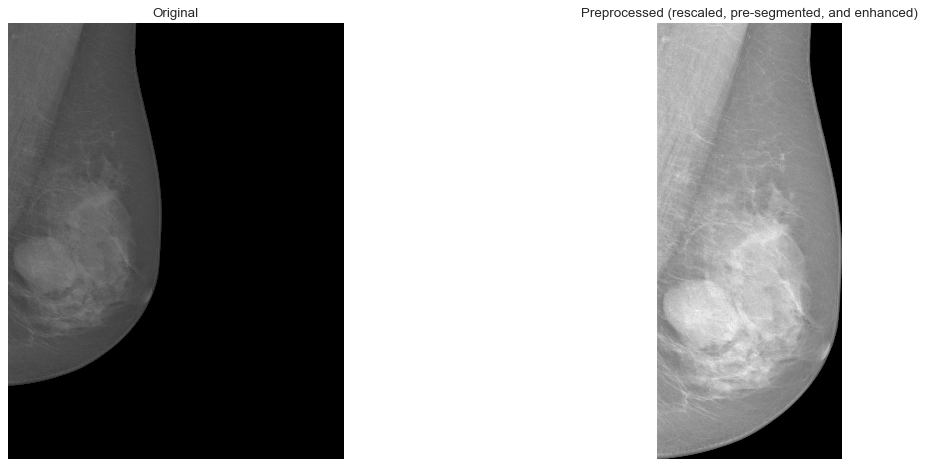

In [8]:
# Reading a single image
random_idx = random.randint(0,120)

img_name = os.listdir(os.path.join(dataset_folder_paths[0][1]))[random_idx]
img_path = os.path.join(dataset_folder_paths[1][1], img_name)

# original image
img = cv2.imread(
    img_path)

# 1. resizing image with a factor of 4 using INTER_CUBIC (bi-cubic) interpolation
scale_factor = 0.4
img_resized = cv2.resize(img.copy(), None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
print(f"Resized Image Shape: {img_resized.shape}")

img_gray = cv2.cvtColor(img_resized.copy(), cv2.COLOR_BGR2GRAY)
print(f"Gray Image Shape: {img_gray.shape}")


# 2. Pre-segmenting using thresholding technique and cropping redundant background
# https://stackoverflow.com/questions/63575738/remove-letter-artifacts-from-mammography-image
# The first argument is the source image, which should be a grayscale image. The second argument is 
# the threshold value which is used to classify the pixel values. The third argument is the maximum value
# which is assigned to pixel values exceeding the threshold. 
thresholding_mask = cv2.threshold(img_gray.copy(), 30, 255, cv2.THRESH_BINARY)[1]
print(f"Thresholded Mask Shape: {thresholding_mask.shape}")

# To remove redundant image, lets find the contours from the mask we generated
contours, _ = cv2.findContours(thresholding_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(largest_contour)
contour_image = cv2.drawContours(img_gray.copy(), [largest_contour], -1, (255, 255, 255), 3)
cropped_image = img_gray.copy()[y:y+h, x:x+w]


# 3. Rescale (Normalize) the image to 16-bit unsigned integer (0-65535)
# Note, clahe expects 8-bit (0-255) not 16 ..
rescaled_img = cv2.normalize(cropped_image.copy(), None, 0, 255, cv2.NORM_MINMAX)


# 4. Applying CLAHE
clahe = cv2.createCLAHE(clipLimit=0.01, tileGridSize=(4,4))
clahe_img = clahe.apply(rescaled_img.copy())

imgs = {
    "Original": img, 
#     "Threshold Mask": thresholding_mask, 
#     "Contour on Gray Image": contour_image, 
#     "Cropped Image (Grayscale Version)": cropped_image, 
#     "Rescaled 16-bit":rescaled_img,
    "Preprocessed (rescaled, pre-segmented, and enhanced)": clahe_img
}

display.plot_figures(imgs, 1,2) 


2023-04-21 19:18:36.417 | INFO     | preprocessing:fit:69 - Started processing pipeline.
100%|███| 1/1 [00:00<00:00,  3.53it/s]
2023-04-21 19:18:36.709 | INFO     | preprocessing:fit:114 - Finished processing 410 files in approximately 0.292 seconds.


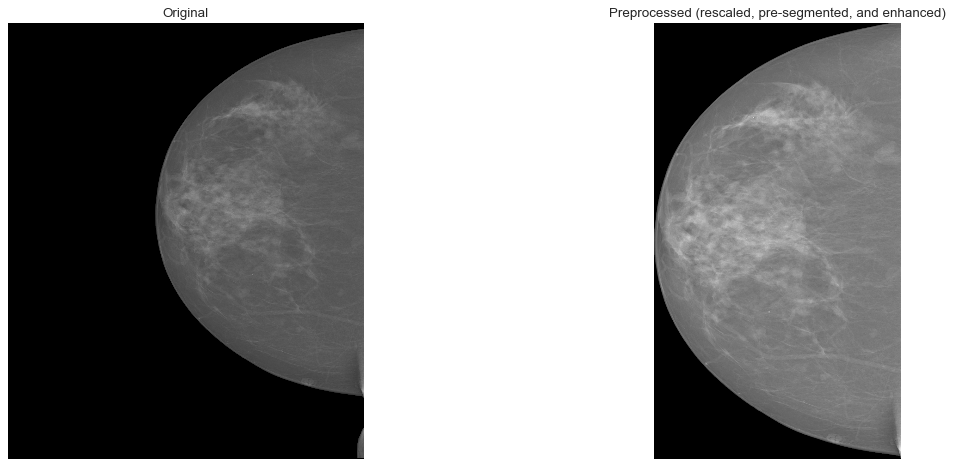

In [9]:
# All of the above is now implemented in a separate class and can be applied using the following line of code
preprocessor.fit(dataset_path=dataset_folder_paths[1][1], 
                 process_n=1, 
                 plot=True, 
                 export_processed=False)

## Region Candidate Generation

Two stages were proposed:
1. Multi-scale morphological shifters
2. Multi-level Otsu thresholding

In [10]:
# def create_linear_structuring_elements(D1, D2, N):
#     """Create two sets of linear structuring elements with magnitudes D1 and D2, and N orientations"""
#     theta = np.linspace(0, 180, N, endpoint=False) # angles equally spaced from 0 to 180 degrees
#     delta_theta = 190 / N # angle difference between adjacent lines
#     elements1 = [cv2.getStructuringElement(cv2.MORPH_RECT, (D1,1), (-1,-1)) 
#                  for theta_n in theta for angle in (theta_n, theta_n + delta_theta)]
#     elements2 = [cv2.getStructuringElement(cv2.MORPH_RECT, (D2,1), (-1,-1)) 
#                  for theta_n in theta for angle in (theta_n, theta_n + delta_theta)]
#     return elements1, elements2

# # def apply_mgmf_l(input_image, elements1, elements2):
# #     """Apply MGMF-L multi-scale morphological filtering on input image with linear structuring elements"""
# #     output_images = []
# #     for element1, element2 in zip(elements1, elements2):
# #         output = cv2.subtract(input_image, cv2.morphologyEx(input_image, cv2.MORPH_OPEN, element2))
# #         output = cv2.morphologyEx(output, cv2.MORPH_OPEN, element1)
# #         output_images.append(output)
# #     output_sum = reduce(cv2.add, output_images)
# # #     output_norm = cv2.normalize(output_sum, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
# #     output_norm = cv2.normalize(output_image, None, 0, 65535, cv2.NORM_MINMAX, dtype=cv2.CV_16U)

# #     return output_norm


# def apply_mgmf_l(input_image, elements1, elements2):
#     """Apply MGMF-L multi-scale morphological filtering on input image with linear structuring elements"""
#     output_images = []
#     for element1, element2 in zip(elements1, elements2):
#         output = cv2.subtract(input_image, cv2.morphologyEx(input_image, cv2.MORPH_OPEN, element2))
#         output = cv2.morphologyEx(output, cv2.MORPH_OPEN, element1)
#         output_images.append(output)
#     output_sum = np.sum(output_images, axis=0)
#     output_sum_umat = cv2.UMat(output_sum)
#     output_norm = cv2.normalize(output_image, None, 0, 65535, cv2.NORM_MINMAX, dtype=cv2.CV_16U)
#     return output_norm


# def estimate_structuring_element_magnitudes(Area_min, Area_max, P, M, R):
#     """Estimate the magnitudes of linear structuring elements for MGMF-L method"""
#     DI_min = 2 * (np.sqrt(Area_min/np.pi) * (P * R)) / (M * 2.0)
#     DI_max = 2 * (np.sqrt(Area_max/np.pi) * (P * R)) / (M * 2.0)
#     return DI_min, DI_max

# # define parameters
# D1 = 7
# D2 = 21
# N = 12
# M = 4
# Area_min = 100
# Area_max = 5000
# P = 0.1
# R = 4

# input_image_name = os.listdir(os.path.join(dataset_folder_paths[4][1], 'images'))[0]
# input_image_path = os.path.join(dataset_folder_paths[4][1], 'images', input_image_name)
# input_image = cv2.imread(input_image_path)

# # input_image = cv2.convertScaleAbs(input_image)

# # Convert the grayscale image to a UMat object
# # gray_umat = cv2.UMat(gray)

# # plt.axis('off')
# # plt.imshow(input_img)
# # plt.show()

# # print(f"Data type: {input_image.dtype}, Shape: {input_image.shape}")


# # create linear structuring elements
# elements1, elements2 = create_linear_structuring_elements(D1, D2, N)

# # estimate structuring element magnitudes
# DI_min, DI_max = estimate_structuring_element_magnitudes(Area_min, Area_max, P, M, R)

# # apply MGMF-L multi-scale morphological filtering on input image
# output_image = apply_mgmf_l(input_image, elements1, elements2)

# # output_umat = cv2.UMat(output_image)

# # output_image

# plt.axis('off')
# plt.imshow(output_image)
# plt.show()


In [11]:
# import os
# import cv2
# import numpy as np
# from functools import reduce

# def create_linear_structuring_elements(D1, D2, N):
#     """Create two sets of linear structuring elements with magnitudes D1 and D2, and N orientations"""
#     theta = np.linspace(0, 180, N, endpoint=False) # angles equally spaced from 0 to 180 degrees
#     delta_theta = 180 / N # angle difference between adjacent lines
#     elements1 = [cv2.getStructuringElement(cv2.MORPH_RECT, (D1,1), (-1,-1)) 
#                  for theta_n in theta for angle in (theta_n, theta_n + delta_theta)]
#     elements2 = [cv2.getStructuringElement(cv2.MORPH_RECT, (D2,1), (-1,-1)) 
#                  for theta_n in theta for angle in (theta_n, theta_n + delta_theta)]
#     return elements1, elements2

# # def apply_mgmf_l(input_image, elements1, elements2):
# #     """Apply MGMF-L multi-scale morphological filtering on input image with linear structuring elements"""
# #     output_images = []
# #     for element1, element2 in zip(elements1, elements2):
# #         output = cv2.subtract(input_image, cv2.morphologyEx(input_image, cv2.MORPH_OPEN, element2))
# #         output = cv2.morphologyEx(output, cv2.MORPH_OPEN, element1)
# #         output_images.append(output)
# #     output_sum = reduce(cv2.add, output_images)
# #     output_norm = cv2.normalize(output_sum, None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_16U)
# #     return output_norm

# def apply_mgmf_l(input_image, elements1, elements2):
#     """Apply MGMF-L multi-scale morphological filtering on input image with linear structuring elements"""
#     output_images = []
#     for element1, element2 in zip(elements1, elements2):
#         output = cv2.subtract(input_image, cv2.morphologyEx(input_image, cv2.MORPH_OPEN, element2))
#         output = cv2.morphologyEx(output, cv2.MORPH_OPEN, element1)
#         output_images.append(output)
#     output_sum = reduce(cv2.add, output_images)
#     output_min = np.min(output_sum)
#     output_max = np.max(output_sum)
#     output_range = output_max - output_min
#     output_norm = ((output_sum - output_min) / output_range * 65535).astype(np.uint16)
#     return output_norm


# def estimate_structuring_element_magnitudes(Area_min, Area_max, P, M, R):
#     """Estimate the magnitudes of linear structuring elements for MGMF-L method"""
#     DI_min = 2 * (np.sqrt(Area_min/np.pi) * (P * R)) / (M * 2.0)
#     DI_max = 2 * (np.sqrt(Area_max/np.pi) * (P * R)) / (M * 2.0)
#     return DI_min, DI_max

# # define parameters
# D1 = 7
# D2 = 21
# N = 18
# M = 4
# Area_min = 100
# Area_max = 5000
# P = 0.1
# R = 4

# input_image_name = os.listdir(os.path.join(dataset_folder_paths[4][1], 'images'))[0]
# input_image_path = os.path.join(dataset_folder_paths[4][1], 'images', input_image_name)
# input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)

# # input_image = cv2.convertScaleAbs(input_image)

# # Convert the grayscale image to a UMat object
# # gray_umat = cv2.UMat(gray)

# # plt.axis('off')
# # plt.imshow(input_img)
# # plt.show()

# # print(f"Data type: {input_image.dtype}, Shape: {input_image.shape}")


# # create linear structuring elements
# elements1, elements2 = create_linear_structuring_elements(D1, D2, N)

# # estimate structuring element magnitudes
# DI_min, DI_max = estimate_structuring_element_magnitudes(Area_min, Area_max, P, M, R)

# # apply MGMF-L multi-scale morphological filtering on input image
# output_image = apply_mgmf_l(input_image, elements1, elements2)


# plt.axis('off')
# plt.imshow(output_image, cmap='gray')
# plt.show()


In [12]:
# # Define parameters
# # D1 = 5
# # D2 = 15
# # N = 8
# delta_theta = 180/N
# num_scales = 4

# D1 = 7
# D2 = 21
# N = 18

# def mgmf_l(image, D1, D2, N, num_scales):
#     angles = np.arange(0, 180, 180/num_scales)
#     delta_theta = 180/num_scales
#     scales = np.arange(1, num_scales+1)
#     filtered_image = np.zeros_like(image, dtype=float)
#     for scale in scales:
#         for angle in angles:
#             kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (D1, D2))
#             kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (D1, D2))
#             kernel2 = cv2.rotate(kernel2, cv2.ROTATE_180)
            
#             kernel1 = rotate_kernel(kernel1, angle)
#             kernel2 = rotate_kernel(kernel2, angle)
            
#             opened1 = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel1)
#             opened2 = cv2.morphologyEx(opened1, cv2.MORPH_OPEN, kernel2)
#             filtered_image += cv2.subtract(image, opened2) * opened1
#     filtered_image /= num_scales
#     filtered_image = (filtered_image * 65535.0 / np.max(filtered_image)).astype(np.uint16)
#     return filtered_image


# def rotate_kernel(kernel, angle):
#     center = tuple(np.array(kernel.shape) / 2)
#     rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
#     return cv2.warpAffine(kernel, rot_mat, kernel.shape, flags=cv2.INTER_NEAREST)



# input_image_name = os.listdir(os.path.join(dataset_folder_paths[4][1], 'images'))[0]
# input_image_path = os.path.join(dataset_folder_paths[4][1], 'images', input_image_name)
# input_image = cv2.imread(input_image_path)


# filtered_image = mgmf_l(input_image, D1, D2, N, num_scales)



# plt.axis('off')
# plt.imshow(filtered_image)
# plt.show()

In [13]:
def Morphological_sifter(M1, M2, orientation, image, L_or_R, padding_option, breast_mask):
    # Create a copy of the input image
    newimage = np.copy(image)
    
    # Get the dimensions of the input image
    m, n = newimage.shape
    
    ## Border effect control: border padding
    # Option 1: pad with highest pixel value
    temp = np.full((m+4*M1, n+4*M1), 65535, dtype=np.uint16)
#     temp[2*M1:2*M1+m, 2*M1:2*M1+n] = newimage
    temp[2*M1:(2*M1+m), 2*M1:(2*M1+n)] = newimage

    
    # Option 2: replicate the pixels on the border
    if padding_option == 1:
        if L_or_R == 1: # left breast
            edge = newimage[:, :min(n, 2*M1)]
            temp[2*M1:2*M1+m, 2*M1-edge.shape[1]:2*M1] = np.fliplr(edge)
        else: # right breast
            edge = newimage[:, max(0, n-2*M1):n]
            temp[2*M1:2*M1+m, n+2*M1:n+2*M1+edge.shape[1]] = np.fliplr(edge)
    
    ## Apply multi-scale morphological sifting
    enhanced_image = np.zeros_like(temp)
    for k in range(len(orientation)):
        B1 = cv2.getStructuringElement(cv2.MORPH_RECT, (M1, 1), (-1, -1))
#         B1 = cv2.warpAffine(B1, cv2.getRotationMatrix2D((M1/2, M1/2), orientation[k], 1), (M1, M1))   
        
        B2 = cv2.getStructuringElement(cv2.MORPH_RECT, (M2, 1), (-1, -1))
#         B2 = cv2.warpAffine(B2, cv2.getRotationMatrix2D((M2/2, M2/2), orientation[k], 1), (M2, M2))
        
        bg1 = cv2.morphologyEx(temp, cv2.MORPH_OPEN, B1)
        r1 = cv2.subtract(temp, bg1)
        r2 = cv2.morphologyEx(r1, cv2.MORPH_OPEN, B2)
        enhanced_image = enhanced_image + r2

    
    enhanced_image = enhanced_image[2*M1:2*M1+m, 2*M1:2*M1+n] # Reset the image into the original size
#     enhanced_image = Normalization_mask(enhanced_image,breast_mask,8);
    enhanced_image = (enhanced_image-enhanced_image.min())/(enhanced_image.max()-enhanced_image.min())*255
    enhanced_image = enhanced_image.astype(np.uint8)
    enhanced_image = cv2.bitwise_and(enhanced_image, enhanced_image, mask=breast_mask.astype(np.uint8))

#     enhanced_image = cv2.normalize(enhanced_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
#     enhanced_image = cv2.bitwise_and(enhanced_image, enhanced_image, mask=breast_mask.astype(np.uint8))
    
    return enhanced_image

def linear_structuring_elements(Num_scale, D, type):
    """
    This function generates the length of the linear structuring elements (LSE) 
    used in morphological filter elements on different scales. Either linear or 
    logarithmic scale interval is used.

    INPUT:
    Num_scale : int : The number of scales used
    D : list : The diameter range of breast masses
    type : str : The scale type (linear or logarithmic)

    OUTPUT:
    len_bank : numpy.ndarray : The magnitudes of the LSEs
    """
    if type == 'linear':
        scale_interval = int((D[1] - D[0]) / Num_scale)
        len_bank = np.zeros(Num_scale + 1, dtype=int)
        for l in range(Num_scale + 1):
            len_bank[l] = D[0] + (l - 1) * scale_interval
        len_bank[Num_scale] = D[1]

    if type == 'exponential':
        scale_interval = (D[1] / D[0]) ** (1 / Num_scale)
        len_bank = np.zeros(Num_scale + 1, dtype=int)
        for l in range(Num_scale + 1):
            len_bank[l] = int(D[0] * (scale_interval ** (l - 1)))
        len_bank[Num_scale] = D[1]

    return len_bank

def Normalization_mask(image, mask, mode):
    # Convert image to double
    image = np.double(image)
    
    # Compute intensity values within the mask
    inten = image[mask == 1]
    
    # Compute minimum and maximum intensity values
    mini = np.min(inten)
    maxi = np.max(inten)
    
    # Normalize image
    image = (image - mini) / abs(maxi - mini)
    
    # Zero out values outside the mask
    image[mask < 1] = 0
    
    # Convert image to the desired mode
    if mode == 8:
        new_im = (image * 255).astype(np.uint8)
    elif mode == 16:
        new_im = (image * 65535).astype(np.uint16)
    elif mode == 'double':
        new_im = image
    else:
        raise ValueError('Invalid mode')
    
    return new_im


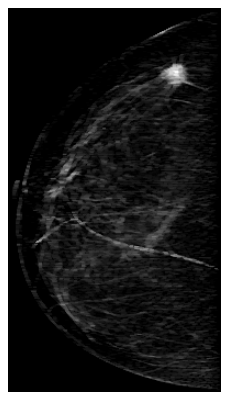

In [25]:
img_name = '20587612_f4b2d377f43ba0bd_MG_R_CC_ANON.tif'
# img_name = '22613822_45c7f44839fd9e68_MG_R_ML_ANON.tif'

img_path = os.path.join(dataset_folder_paths[4][1], 'images',img_name)
image = cv2.imread(img_path)

area_min = 15
area_max = 3689
mass_size_range = [area_min, area_max] # square mm

pixel_size = 0.07 # spatial resolution of the INbreast mammograms, 0.07mm

resize_factor = 4
resize_ratio = 1 / resize_factor

n_scale = 2

n_lse_elements = 18

mass_diameter_range_pixel = [math.floor((mass_size_range[0]/math.pi)**0.5*2/(pixel_size/resize_ratio)),
                             math.ceil((mass_size_range[1]/math.pi)**0.5*2/(pixel_size/resize_ratio))] # diameter range in pixels


lse = linear_structuring_elements(n_scale, mass_diameter_range_pixel, 'exponential')
angle_range = list(range(0, 190, n_lse_elements))


image = image[:,:,0]
breast_mask = (image > 0)
(cA, _) = dwt2(image, 'db2')
(image, _) = dwt2(cA, 'db2')

(cA, _) = dwt2(breast_mask, 'db2')
(breast_mask, _) = dwt2(cA, 'db2')
breast_mask = (breast_mask >= 1)

new_im = Normalization_mask(image,breast_mask,8);

CC_OR_ML = 1 if '_CC_' in img_name else 0
L_OR_R = 1 if '_L_' in img_name else 0

# Loop across all images
enhanced_image = []

for j in range(1, n_scale+1):
    # Boundary padding
    padding_mode = 1
    if j == 1 or CC_OR_ML == 1:
        # if it is a small scale or it is a MLO view
        padding_mode = 0  # highest value padding
    enhanced_image.append(Morphological_sifter(lse[j], lse[j-1], angle_range, new_im, L_OR_R, padding_mode, breast_mask))


# Pseudo_color_im = np.dstack((new_im, enhanced_image[0], enhanced_image[1]))


enhanced_image = np.sum(enhanced_image, axis=0)

# enhanced_image = cv2.normalize(enhanced_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Grayscale normalization
# max_pixel_value = np.max(enhanced_image)
# if max_pixel_value > 0:
#     enhanced_image = (enhanced_image / max_pixel_value) * 255

# otsu_threshold, binary_image = cv2.threshold(enhanced_image.astype('uint8'), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    
plt.axis('off')
plt.imshow(enhanced_image, cmap='gray')
plt.show()